In [1]:
import os
import pandas as pd
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd



2025-04-16 23:41:26.801401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 23:41:26.807743: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 23:41:26.854251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 23:41:26.903575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744821686.950280    4487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744821686.96

In [5]:
pose_dinamic2= [item for item in output_mlp2 if item.endswith('1') or item.endswith('2')]
pose_dinamic2

['cepat2', 'paham2', 'tidak1', 'lihat2', 'menang2', '10_2', 'j2']

In [40]:
z='asu'
z[:2]

'as'

In [24]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import tensorflow as tf
import threading
import time
import pickle
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

# === Output Lists ===
output_mlp = ['cepat1','paham1','tidak1','lihat1','menang1','z','a','i','k']
output_mlp2 = ['cepat2','paham2','tidak1','lihat2','menang2','z','10_2','j2','k']
output_lstm = ['cepat','paham','tidak','lihat','menang','z','10','j','kita']
pose_dinamic1 = [item for item in output_mlp if item.endswith('1')]
pose_dinamic2= [item for item in output_mlp2 if item.endswith('1') or item.endswith('2')]
repetitif =0
# === Utility Functions ===
def scale_points(points, new_x_max):
    x_max_original = np.max(points[:, 0])
    scale = new_x_max / x_max_original
    transformed_points = points * scale
    return transformed_points[:, 0], transformed_points[:, 1]

def normalisasi(data):
    return data - np.min(data)

def trim_sequence(seq, target_len=25):
    if len(seq) <= target_len:
        return list(seq)
    keep_first = seq[0]
    keep_last = seq[-1]
    middle = list(seq)[1:-1]
    step = len(middle) / (target_len - 2)
    trimmed_middle = [middle[int(i * step)] for i in range(target_len - 2)]
    return [keep_first] + trimmed_middle + [keep_last]

# === Load Models and Label Maps ===
with open('csv/label map/dinamic.pkl', 'rb') as f:
    label_map = pickle.load(f)

with open('csv/label map/static.pkl', 'rb') as f:
    label_map_static = pickle.load(f)

model_dynamic = tf.keras.models.load_model("model/dinamic/1.h5")
model_static = tf.keras.models.load_model("model/static/model_1.h5")

frame_count = model_dynamic.input_shape[1]
feature_per_frame = model_dynamic.input_shape[2]

cols_X = sorted([1,9,10,12,13,16,17,20,4,6,8,11,16])
cols_Y = sorted([2,3,4,7,9,10,11,12,15,19,20,16,17])
cols_Z = [5,8,12,20]
cols_RX = [4,6,8,10,12,16,19,20]
cols_RY = [4,6,8,10,12,16,19,20]
column_numbersY = sorted([12,2,16,5,20,8,0,3,4,15,7,11,13,10,19,17])
column_numbersX = sorted([1,3,4,20,8,12,10,16,6,14,18,7,11])
column_numbersZ = [2,4]
titik_stabil = [4,8,12,16,20] 

# === Shared Variables ===
pred_output = ""
current_output = ""  # For thread-safe output display
start = 0
hasil_akhir = None
pose_awal_terdeteksi = False
pose_akhir_terdeteksi = False
array_spatial = []
p1 = p2 = None
pose_awal_waktu = 0
sequence_active = False  # To track if we're in a dynamic sequence
last_static_time = 0
static_cooldown = 1.0  # Seconds to wait after static gesture
mlp_active = False
prev_label = ""
# Setup untuk MediaPipe Hand Detector
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

lock_output = threading.Lock()
lock_state = threading.Lock()  # For state variables

# === Video Thread ===
class VideoCaptureThread:
    def __init__(self, src=1):
        self.cap = cv2.VideoCapture(src)
        self.ret, self.frame = self.cap.read()
        self.running = True
        self.lock = threading.Lock()
        thread = threading.Thread(target=self.update, daemon=True)
        thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                with self.lock:
                    self.ret = ret
                    self.frame = frame

    def read(self):
        with self.lock:
            return self.ret, self.frame.copy() if self.frame is not None else (False, None)

    def release(self):
        self.running = False
        if self.cap.isOpened():
            self.cap.release()

def static_prediction_thread(vc):
    global pred_output, pose_awal_terdeteksi, pose_akhir_terdeteksi, p1, p2, array_spatial,prev_label,mlp_active
    global hasil_akhir, sequence_active, last_static_time, current_output,repetitif
    
    prev_points = None
    stable_frames_counter = 0
    stable_frames_required = 3 
    stability_threshold = 0.02      
    last_prediction = None
    last_prediction_time = 0
    prediction_cooldown = 1.0  # seconds
    
    while vc.running:
        ret, frame = vc.read()
        if not ret:
            continue

        current_time = time.time()
        
        # Skip processing if we're in a dynamic sequence
        if sequence_active and (current_time - last_static_time < static_cooldown)  :
            continue
        # elif sequence_active and (current_time - last_static_time>static_cooldown) :
        #     print('hello')
# and not mlp_active
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        result = detector.detect(mp_image)

        if result.hand_landmarks:
            hand = result.hand_landmarks[0]
            nilai_X = np.array([lm.x for lm in hand])
            nilai_Y = np.array([lm.y for lm in hand])
            nilai_Z = np.array([lm.z for lm in hand])[column_numbersZ]

            curr_points = np.array([[nilai_X[i], nilai_Y[i]] for i in titik_stabil])

            if prev_points is not None:
                delta = np.linalg.norm(curr_points - prev_points, axis=1)
                mean_delta = np.mean(delta)

                if mean_delta < stability_threshold:
                    stable_frames_counter += 1
                else:
                    stable_frames_counter = 0
            else:
                stable_frames_counter = 0

            prev_points = curr_points.copy()

            if stable_frames_counter >= stable_frames_required:
                newX = normalisasi(nilai_X)
                newY = normalisasi(nilai_Y)
                newXY = np.column_stack((newX, newY))
                newX, newY = scale_points(newXY, 1)

                fiturX = newX[column_numbersX]
                fiturY = newY[column_numbersY]

                features = np.concatenate((fiturX, fiturY, nilai_Z)).astype(np.float32)
                input_data = np.expand_dims(features, axis=0)

                prediction = model_static.predict(input_data, verbose=0)
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                label = label_map_static[predicted_class]

                if confidence >= 0.8 and (current_time - last_prediction_time > prediction_cooldown or label != last_prediction):
                    last_prediction_time = current_time
                    last_prediction = label

                    # if mlp_active and label not in output_mlp2 and pose_awal_terdeteksi:
                    
                    with lock_state:
                        # if mlp_active and label in pose_dinamic2:

                        #     mlp_active = False



                        if mlp_active and label not in output_mlp and label not in output_mlp2:
                            # Mismatched start/end - cancel sequence
                            pose_awal_terdeteksi = False
                            pose_akhir_terdeteksi = False
                            sequence_active = False
                            array_spatial = []
                            mlp_active=False
                            with lock_output:
                                pred_output += prev_label
                        elif mlp_active and label in output_mlp:
                            p1 = output_mlp.index(label)
                            pose_awal_terdeteksi = True
                            array_spatial = []
                            last_static_time = current_time
                            sequence_active = True
                            with lock_output:
                                current_output = f"{label} (start)"
                            if label not in pose_dinamic1:
                                if label =='a':
                                    print('a')
                                mlp_active=True
                                pred_output+=prev_label

                                prev_label=label
                                repetitif+=1
                                

                        if label in output_mlp and not pose_awal_terdeteksi and not sequence_active:
                            # Start of dynamic sequencelabel
                            p1 = output_mlp.index(label)
                            pose_awal_terdeteksi = True
                            array_spatial = []
                            last_static_time = current_time
                            sequence_active = True
                            with lock_output:
                                current_output = f"{label} (start)"
                            if label not in pose_dinamic1:
                                mlp_active=True
                                prev_label+=label
                                
                        
                            
                        elif label in output_mlp2 and pose_awal_terdeteksi and sequence_active:
                            # End of dynamic sequence
                            p2 = output_mlp2.index(label)
                            if p1 == p2:
                                pose_akhir_terdeteksi = True
                                last_static_time = current_time
                                if mlp_active:
                                    mlp_active=False
                                with lock_output:
                                    
                                    current_output = f"{output_mlp[p1]} (end)"
                                
                                    ###############
                            

                        


##################################
                            else:
                                # Mismatched start/end - cancel sequence
                                pose_awal_terdeteksi = False
                                pose_akhir_terdeteksi = False
                                sequence_active = False
                                array_spatial = []
                                with lock_output:
                                    current_output = f"{output_mlp[p1]} (canceled)"
                        elif sequence_active and label not in output_mlp2 :
                            pose_awal_terdeteksi = False
                            pose_akhir_terdeteksi = False
                            sequence_active = False
                            array_spatial = []
                            pred_output+=label
                            # if label not in output_mlp:
                            #     pred_output+=label
                            # elif label in output_mlp:
                            #     p1 = output_mlp.index(label)
                            #     pose_awal_terdeteksi = True
                            #     array_spatial = []
                            #     last_static_time = current_time
                            #     sequence_active = True
                            #     with lock_output:
                            #         current_output = f"{label} (start)"
                            #     if label not in pose_dinamic1:
                            #         mlp_active=True
                            #         prev_label+=label



                            
                        elif not sequence_active and label not in output_mlp and label not in output_mlp2:
                            # Regular static gesture
                            
                            with lock_output:
                                if current_output and not current_output.endswith(label):
                                    pred_output += f"{label}"
                                  
                                    current_output = label
                                elif not current_output:
                                    pred_output += f"{label}"
                                    current_output = label
                                last_static_time = current_time
        else:
            prev_points = None
            stable_frames_counter = 0
            with lock_state:
                if sequence_active and (current_time - last_static_time > 2.0):
                    # Timeout for dynamic sequences
                    pose_awal_terdeteksi = False
                    pose_akhir_terdeteksi = False
                    sequence_active = False
                    array_spatial = []
                    with lock_output:
                        if p1 is not None:
                            current_output = f"{output_mlp[p1]} (timeout)"

def dynamic_prediction_thread(vc):
    global pred_output, pose_awal_terdeteksi, pose_akhir_terdeteksi, p1, p2, array_spatial
    global hasil_akhir, sequence_active, current_output
    
    X_before = Y_before = None
    last_frame_time = time.time()
    min_frame_interval = 0.033  # ~30fps
    
    while vc.running:
        current_time = time.time()
        if current_time - last_frame_time < min_frame_interval:
            time.sleep(0.001)
            continue
        
        last_frame_time = current_time
        
        with lock_state:
            if not pose_awal_terdeteksi or not sequence_active:
                continue
        
        ret, frame = vc.read()
        if not ret:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
        result = detector.detect(mp_image)

        if result.hand_landmarks:
            hand = result.hand_landmarks[0]
            nilaiX = np.array([lm.x for lm in hand])
            nilaiY = np.array([lm.y for lm in hand])
            nilaiZ = np.array([lm.z for lm in hand])[cols_Z]

            try:
                vektorX = nilaiX[cols_RX] - X_before
                vektorY = nilaiY[cols_RY] - Y_before
            except:
                vektorX = [0] * len(cols_RX)
                vektorY = [0] * len(cols_RY)

            X_before = nilaiX[cols_RX]
            Y_before = nilaiY[cols_RY]
            newX = normalisasi(nilaiX)
            newY = normalisasi(nilaiY)
            newXY = np.column_stack((newX, newY))
            newX, newY = scale_points(newXY, 1)
            
            features2 = np.concatenate([
                np.array(newX)[cols_X],
                np.array(newY)[cols_Y],
                np.array(nilaiZ),
                np.array(vektorX),
                np.array(vektorY)
            ])

            with lock_state:
  
                if pose_awal_terdeteksi and sequence_active:
                    array_spatial.append(features2)
                    
                    # Check for sequence timeout
                    if len(array_spatial) > 60:  # ~2 seconds at 30fps
                        pose_awal_terdeteksi = False
                        pose_akhir_terdeteksi = False
                        sequence_active = False
                        array_spatial = []
                        with lock_output:
                            if p1 is not None:
                                current_output = f"{output_mlp[p1]} (timeout)"
                        continue
                        
                    if pose_akhir_terdeteksi and len(array_spatial) >= 25:
                        try:
                            trimmed = trim_sequence(array_spatial, 25)
                            input_data = np.array(trimmed).reshape(1, 25, feature_per_frame)
                            prediction = model_dynamic.predict(input_data, verbose=0)
                            p_lstm = np.argmax(prediction)
                            lstm_label = label_map[p_lstm]
                            
                            if lstm_label in output_lstm:
                                if p1 == p2 and p1 == output_lstm.index(lstm_label):
                                    with lock_output:
                                        pred_output += f" {lstm_label}"
                                        current_output = lstm_label
                                else:
                                    with lock_output:
                                        current_output = f"{output_mlp[p1]} (mismatch)"
                        except Exception as e:
                            print(f"LSTM prediction error: {e}")
                            with lock_output:
                                current_output = f"{output_mlp[p1]} (error)"
                        
                        # Reset sequence
                        pose_awal_terdeteksi = False
                        pose_akhir_terdeteksi = False
                        sequence_active = False
                        array_spatial = []

# === Main Execution ===
vc = VideoCaptureThread()
threading.Thread(target=static_prediction_thread, args=(vc,), daemon=True).start()
threading.Thread(target=dynamic_prediction_thread, args=(vc,), daemon=True).start()

time.sleep(1)  # Allow threads to initialize

while True:
    ret, frame = vc.read()
    if not ret:
        break

    with lock_output:
    
        display_text = current_output if current_output else pred_output
        display_text2 = pred_output
    
    cv2.putText(frame, f"Output: {display_text2}", (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200, 100, 255), 2)
    
    # Show state information for debugging
    state_info = [
        f"State: {'MLP' if not sequence_active else 'LSTM'}",
        f"Sequence: {'Active' if sequence_active else 'Inactive'}",
        f"Pose Start: {'Yes' if pose_awal_terdeteksi else 'No'}",
        f"Pose End: {'Yes' if pose_akhir_terdeteksi else 'No'}",
        f"Frames: {len(array_spatial)}"
    ]
    
    for i, info in enumerate(state_info):
        cv2.putText(frame, info, (10, 90 + i*25), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 0, 100), 1)

    cv2.imshow("Gesture Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vc.release()
cv2.destroyAllWindows()

I0000 00:00:1747076731.411280   71008 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1747076731.412854  109137 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1747076731.423296  109140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747076731.433239  109151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [95]:
data = []
for i, di in enumerate(df['Label'].unique()):
    for a in range(df[df.Label == di].shape[0]):
        # print(np.array(df[df.Label == 'a'].iloc[a].to_list()))
        data.append(df[df.Label == di].iloc[a,:-1].to_list())
 
    # Iterasi untuk setiap nilai unik di 'Sub 2'
      

all_Data = np.array(data)


In [96]:
from sklearn.preprocessing import LabelEncoder
y = np.array(df.Label.to_list())
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)
from tensorflow.keras.utils import to_categorical
y_encoded = to_categorical(y_encoded)
print(y_encoded)

[19 19 19 ...  8  8  8]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [97]:
from sklearn.model_selection import train_test_split

y = np.array(df.Label.to_list())
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(all_Data, y_encoded, test_size=0.2, random_state=42,stratify=y)

In [98]:
X_train_s,

(array([[0.08535402, 0.14946549, 0.10223724, ..., 0.06540644, 0.13583893,
         0.00223383],
        [0.05668053, 0.11456048, 0.0505017 , ..., 0.34036195, 0.27011216,
         0.39167356],
        [0.11576417, 0.12741372, 0.06933007, ..., 0.17656809, 0.18063915,
         0.15701318],
        ...,
        [0.03059113, 0.09013024, 0.07960719, ..., 0.06589188, 0.        ,
         0.07704501],
        [0.        , 0.05354645, 0.08059401, ..., 0.10896283, 0.06107718,
         0.11258316],
        [0.03594743, 0.0939216 , 0.06445196, ..., 0.16549873, 0.09633905,
         0.21532351]]),)

In [99]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

DYNAMIC DATA

In [100]:
data_time_series = []

df = pd.read_csv('csv/coba1_ragged.csv')
# Iterasi untuk setiap nilai unik di 'Label'
for i, di in enumerate(df['Label'].unique()):
    data_time_series.append([])
    
    # Iterasi untuk setiap nilai unik di 'Sub 2'
    for i2, d2 in enumerate(df['Sub 2'].unique()):
        data_time_series[i].append([])
        
        # Filter data berdasarkan kondisi yang benar
        filtered_data = df[(df['Sub 2'] == d2) & (df['Label'] == di)]
        
        # Cetak data yang sudah difilter untuk memeriksa hasil
    
        
        # Iterasi atas data yang sudah difilter
        for i3, row in filtered_data.iterrows():
            # Ambil nilai kolom pertama hingga ke-21 dan masukkan ke dalam list
            data_time_series[i][i2].append([row.iloc[:19].tolist()])

data = np.array(data_time_series)
Y_train = np.array(df['Label'].unique())
Y_train

array(['paham', 'percaya', 'tidak', 'kita'], dtype=object)

In [101]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_train)
y_encoded=[0,1,2,3]
# Membagi data berdasarkan dimensi kedua (44)
X_train, X_test, y_train, y_test = [], [], [], []

# Menggunakan loop untuk membagi data per label
for i in range(data.shape[0]):  # iterasi untuk setiap label (4 label)
    X_label = data[i]  # Ambil data untuk label ke-i
    y_label = y_encoded [i]  # Ambil target yang sudah diencode untuk label ke-i
    
    # Split data time series (44 data menjadi 80% untuk training, 20% untuk testing)
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        X_label, 
        [y_label] * len(X_label),  # Targetnya sama untuk semua time series dalam satu label
        test_size=0.2, 
        random_state=42
    )
    
    # Append hasil split untuk label ke-i
    X_train.append(X_train_label)
    X_test.append(X_test_label)
    y_train.append(y_train_label)
    y_test.append(y_test_label)

# Mengonversi ke array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Menampilkan bentuk hasil split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4, 47, 38, 1, 19) (4, 12, 38, 1, 19) (4, 47) (4, 12)


In [102]:
y_train = y_train.reshape(4*47,)
y_test = y_test.reshape(4*12,)

In [103]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
y_train = y_train.reshape(4*47,)
y_test = y_test.reshape(4*12,)
# Mengubah bentuk X_train dan X_test menjadi format yang sesuai untuk LSTM
X_train_reshaped = X_train.reshape(4*47, 38, 19)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
X_test_reshaped = X_test.reshape(4*12, 38 , 19)  # Menggabungkan fitur 38 dan 21 menjadi 798
# X_train_reshaped = X_train.reshape(4, 35, 38 * 21)  # Menggabungkan fitur 38 dan 21 menjadi 798 4, 35, 38 * 21
# X_test_reshaped = X_test.reshape(4,9, 38* 21)  # Menggabungkan fitur 38 dan 21 menjadi 798

# Mengonversi label ke one-hot encoding (karena menggunakan categorical crossentropy)
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)


In [104]:
y_train_one_hot.shape

(188, 4)

In [105]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Input
input_layer1 = tf.keras.Input(shape=(38, 19))

# Bidirectional LSTM layer
x1 = layers.Bidirectional(layers.LSTM(32))(input_layer1)

# Dropout layer
x1 = layers.Dropout(0.3)(x1)

# Dense layer dengan ReLU activation
x1= layers.Dense(16, activation='relu')(x1)

# Output layer dengan softmax activation
output_layer1 = layers.Dense(4, activation='softmax')(x1)

# # Membuat model
# model = Model(inputs=input_layer, outputs=output_layer)

# # Menampilkan summary model
# model.summary()


In [86]:
input_layer2 = tf.keras.Input(shape=(24,))

# Dense layer pertama dengan ReLU activation
x2 = layers.Dense(64, activation='relu')(input_layer2)

# Dense layer kedua dengan ReLU activation
x2 = layers.Dense(64, activation='relu')(x2)

# Dropout layer
x2 = layers.Dropout(0.2)(x2)

# Dense layer ketiga dengan ReLU activation
x2 = layers.Dense(64, activation='relu')(x2)

# Output layer dengan softmax activation (4 kelas)
output_layer2 = layers.Dense(24, activation='softmax')(x2)

# Membuat model
# model = Model(inputs=input_layer, outputs=output_layer)

# # Menampilkan summary model
# model.summary()

In [87]:
x = tf.keras.layers.concatenate([output_layer1,output_layer2])
# x = tf.keras.layers.concatenate([x1,x2])

In [88]:
priority_pred = layers.Dense(1, name="priority",activation ='sigmoid')(x)


In [58]:
model = tf.keras.Model(
    inputs=[output_layer1,output_layer2],
    outputs=[priority_pred],
)

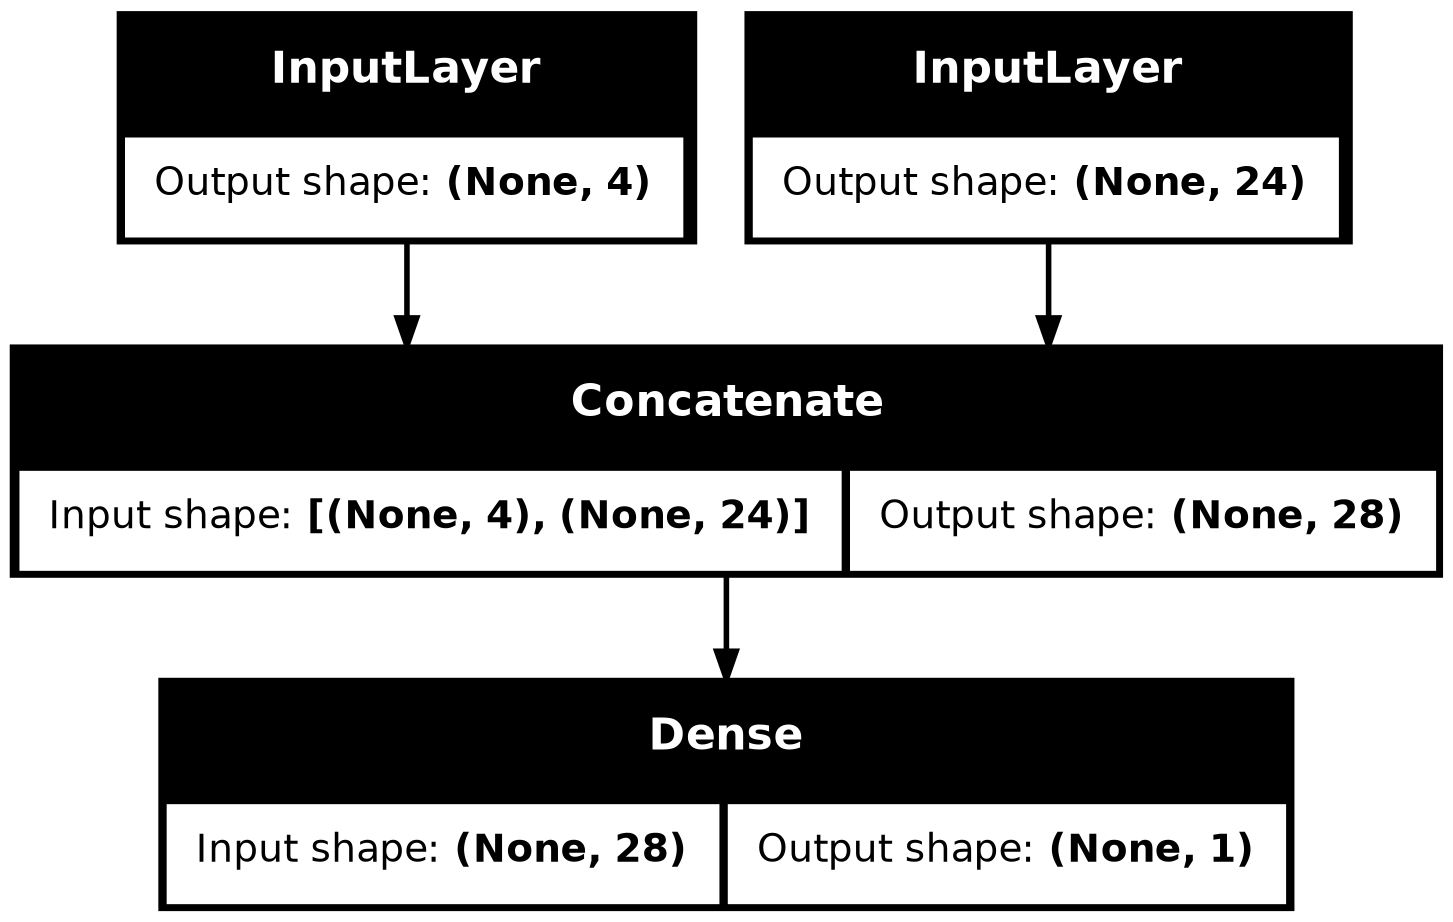

In [59]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
history = model.fit(
    [X_train_reshaped, X_train_s],  # Input data: satu untuk data dinamis dan satu untuk data statis
    [ y_train_one_hot, y_train_s],                     # Target labels
    epochs=20,                   # Jumlah epoch
    batch_size=16,               # Ukuran batch
    validation_data=([X_test_reshaped, X_test_s], [y_test_one_hot, y_test_s]),  # Data validasi untuk multi-input
             # Callbacks untuk pelatihan
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 188, 2355
'y' sizes: 188, 2355


In [107]:
X_train_s = X_train_s[:min(X_train_s.shape[0], X_train_reshaped.shape[0])]
X_train_reshaped = X_train_reshaped[:min(X_train_s.shape[0], X_train_reshaped.shape[0])]
y_train_s = y_train_s[:min(X_train_s.shape[0], y_train_s.shape[0])]

In [109]:
X_train_s.shape,X_train_reshaped.shape

((188, 24), (188, 38, 19))

In [108]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# Model 1 (Statis)
input_static = Input(shape=(24,))  # Input untuk data statis (misalnya X_train)
x1 = Dense(64, activation='relu')(input_static)
x1 = Dense(64, activation='relu')(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(64, activation='relu')(x1)
output_static = Dense(24, activation='softmax')(x1)

# Model 2 (Time-Series)
input_dynamic = Input(shape=(38, 19))  # Input untuk data time-series (misalnya X_train_reshaped)
x2 = Bidirectional(LSTM(32))(input_dynamic)
x2 = Dropout(0.3)(x2)
x2 = Dense(16, activation='relu')(x2)
output_dynamic = Dense(4, activation='softmax')(x2)

# Gabungkan kedua output model
combined = Concatenate()([output_static, output_dynamic])

# Layer output akhir
final_output = Dense(4, activation='softmax')(combined)

# Buat model final
model = Model(inputs=[input_static, input_dynamic], outputs=final_output)

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Latih model dengan data gabungan
history = model.fit(
    [X_train_s, X_train_reshaped],  # Data input: X_train untuk statis, X_train_reshaped untuk dinamis
    y_train_s,  # Target labels
    epochs=20,
    batch_size=4,
    validation_data=([X_test_s, X_test_reshaped], y_test_s),
    verbose=2,
    shuffle=True
)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 64)        │      1,600 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_33      │ (None, 38, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 64)        │      4,160 │ dense_91[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 64)        │     13,312 │ input_layer_33[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 64)        │          0 │ bidirectional_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 64)        │      4,160 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 16)        │      1,040 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 24)        │      1,560 │ dense_93[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 4)         │         68 │ dense_95[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 28)        │          0 │ dense_94[0][0],   │
│ (Concatenate)       │                   │            │ dense_96[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 4)         │        116 │ concatenate_14[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,016 (101.62 KB)

 Trainable params: 26,016 (101.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(4, 24), output.shape=(4, 4)

In [71]:
print(X_train_reshaped.shape)  # Memeriksa bentuk data dinamis
print(X_train_s.shape)         # Memeriksa bentuk data statis
print(y_train_s.shape)         # Memeriksa bentuk label target


(188, 38, 19)
(188, 24)
(188, 24)
